# Подготовка датасета

In [ ]:
!pip install json5 gdown sentence-transformers -q

In [ ]:
import json5
import sqlite3
from tqdm import tqdm
import pandas as pd
from unittest import TestCase, TextTestRunner, defaultTestLoader
import os, re, time
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt

In [235]:
!gdown 1Xjbp207zfCaBxhPgt-STB_RxwNo2TIW2

Downloading...
From (original): https://drive.google.com/uc?id=1Xjbp207zfCaBxhPgt-STB_RxwNo2TIW2
From (redirected): https://drive.google.com/uc?id=1Xjbp207zfCaBxhPgt-STB_RxwNo2TIW2&confirm=t&uuid=adfe8307-2da8-4dcb-bb3d-85a3bf0d0186
To: e:\repos\ai-analyser\merged_database_2022-06-10.zip

  0%|          | 0.00/325M [00:00<?, ?B/s]
  0%|          | 524k/325M [00:00<04:24, 1.23MB/s]
  0%|          | 1.05M/325M [00:00<02:27, 2.20MB/s]
  1%|          | 2.10M/325M [00:00<01:15, 4.29MB/s]
  1%|▏         | 4.19M/325M [00:00<00:37, 8.46MB/s]
  2%|▏         | 7.34M/325M [00:00<00:21, 14.6MB/s]
  4%|▍         | 12.6M/325M [00:00<00:12, 24.8MB/s]
  5%|▍         | 15.7M/325M [00:01<00:19, 16.1MB/s]
  6%|▌         | 18.4M/325M [00:01<00:21, 14.2MB/s]
  6%|▋         | 21.0M/325M [00:01<00:24, 12.3MB/s]
  8%|▊         | 24.6M/325M [00:01<00:20, 14.6MB/s]
  8%|▊         | 26.7M/325M [00:02<00:19, 15.3MB/s]
  9%|▉         | 28.8M/325M [00:02<00:19, 15.4MB/s]
 10%|▉         | 30.9M/325M [00:02<00:22, 13

In [236]:
import zipfile
def unzip_file(path, path_to):
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(path_to)

unzip_file('merged_database_2022-06-10.zip', 'pauq_databases')

In [327]:
def load_table(database_path : str, queries_table_path : str, db_id : str):
    queries = pd.read_json(queries_table_path)
    queries = queries[queries['db_id'] == db_id]

    sqlite_conn = sqlite3.connect(os.path.join(database_path, f'{db_id}.sqlite'))
    schema = open('schema.sql').read()

    db = sqlite_conn.cursor()
    try:
        db.executescript(schema)
    except:
        print('Some problem occured during schema execution')
    return sqlite_conn, queries

conn, queries = load_table(r'.\pauq_databases\merged_database\geo', r'.\distilled-dataset\dataset\pauq_train.json', 'geo')
queries = queries.reset_index()
db = conn.cursor()

Some problem occured during schema execution


# Краткий инференс моделей

| model               | accuracy | sql sim. | mean exec. time (20 samples) | RAM   | GPU Mem. |
|---------------------|----------|----------|------------------------------|-------|----------|
| sqlcoder-7b-2       | **0.15**     | 0.741    |             2.438            | ~**7gb**  | ~14gb    |
| Chat2DB-SQL-7B      | **0.15**     | **0.839**    |             **1.509**            | ~8gb  | ~**8gb**    |
| DuckDB-NSQL-7B-v0.1 | 0.05     | 0.762    |             1.669            | ~8gb  | ~14gb    |
| _internlm2_5-7b_     | 0.0      | 0.483    |            33.231            | ~10gb | ~20gb    |

Как видно из таблицы, лучше всего себя показала модель Chat2DB-SQL-7B, хуже всего - internlm. Однако на данный момент эти данные мало о чём говорят потому, что, во-первых, для сравнения таблиц используется "сырое" равенство между двумя python-массивами, во-вторых, в промпте указано довольно-таки мало информации (например, отсутствует Cell Value Reference и Schema Linking), в-третьих, модель _internlm2_5-7b_ вовсе является моделью общего назначения и пока что ведёт себя непредсказуемо (на запрос на естественном языке может выдать множество SQL-запросов с пояснениями, хотя в промпте просили выдавать ответ без них).

In [2]:
# Пришлось по отдельности вычислять значения моделей на датасете, т.к среда не тянет больше одной LLM-ки одновременно. Или тянет, но тогда это сильно сказывается на скорости выполнения
sqlcoder = [2.2369444370269775, 1.2355380058288574, 1.8206593990325928, 4.242553472518921, 2.7599916458129883, 4.4950525760650635, 1.7857539653778076, 1.8319032192230225, 4.249694347381592, 1.1512413024902344, 1.9609730243682861, 1.7273619174957275, 2.6429495811462402, 2.5273468494415283, 2.9637715816497803, 2.5321526527404785, 2.4652719497680664, 1.9069654941558838, 1.8566584587097168, 2.3530471324920654]
chat2db = [2.482621192932129, 1.2067625522613525, 1.2091491222381592, 2.3402109146118164, 1.03086256980896, 1.5266852378845215, 0.9082696437835693, 1.4127106666564941, 1.2485144138336182, 0.9084548950195312, 0.966902494430542, 1.5396132469177246, 2.2168426513671875, 1.6644635200500488, 1.3834388256072998, 1.7178280353546143, 1.097515344619751, 1.7943229675292969, 1.7270333766937256, 1.7964227199554443]
duckdb = [2.076850414276123, 1.3486504554748535, 1.2256524562835693, 1.2257285118103027, 3.560006856918335, 1.7321102619171143, 1.916945219039917, 1.5647597312927246, 1.6077048778533936, 1.233952522277832, 1.5506513118743896, 1.297882318496704, 2.118703842163086, 2.3147096633911133, 1.934046745300293, 1.3695087432861328, 1.3092124462127686, 1.3505096435546875, 1.3129842281341553, 1.3219778537750244]
internlm = [35.891454458236694, 33.713053464889526, 33.48268175125122, 32.682185649871826, 31.122331380844116, 33.83864378929138, 32.84711718559265, 32.28859829902649, 31.499861240386963, 33.736652135849, 33.76218771934509, 33.92374777793884, 32.96854782104492, 32.44618511199951, 32.29519033432007, 33.73952555656433, 34.07122468948364, 33.43252372741699, 33.668530225753784, 33.208176612854004]

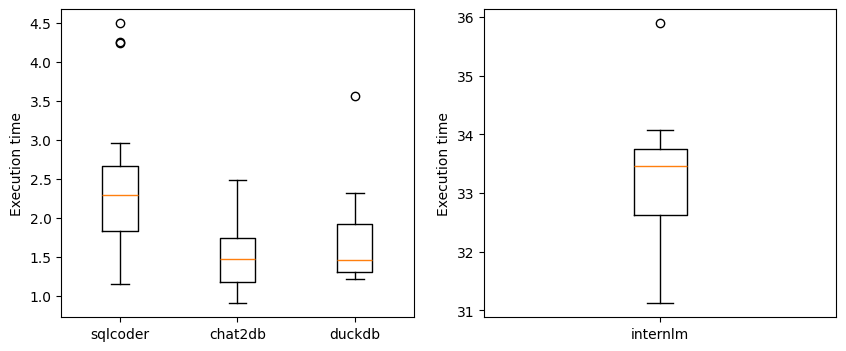

In [5]:
ax, (fig1, fig2) = plt.subplots(ncols=2, figsize=(10, 4))
fig1.set_ylabel('Execution time')
fig1.boxplot([sqlcoder, chat2db, duckdb], labels=['sqlcoder', 'chat2db', 'duckdb'])
fig2.set_ylabel('Execution time')
_ = fig2.boxplot([internlm], labels=['internlm'])

In [220]:
def table_similarity(dataframe1 : pd.DataFrame, dataframe2 : pd.DataFrame, mode : str) -> int:
    if dataframe1.columns.shape != dataframe2.columns.shape:
        return False
    if not (dataframe1.columns == dataframe2.columns).all():
        return False
    
    match mode:
        case 'soft':
            return int(dataframe1.sort_index().equals(dataframe2.sort_index()))
        case 'strict':
            return int(dataframe1.equals(dataframe2))
        case 'flexible':
            intersection = dataframe1.merge(dataframe2).shape[0]
            union = pd.concat([dataframe1, dataframe2]).duplicated()
            union = union[union == False].count()

            return intersection / union if union != 0 else 1
        case _:
            raise Exception('Incorrect mode value')

# Препроцессинг промпта


In [2]:
sentence_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
prompt = '''
### Ответь на вопрос SQLite запросом и без объяснений.
### Примеры похожих задач и ответы на них:

{}

### Схемы таблиц:

{}

### Примеры данных в таблице:

{}

### Вопрос: {}
### SQL:
'''

Schema template

In [ ]:
sql_master = pd.read_sql('SELECT * FROM sqlite_master', conn)
tables = sql_master[sql_master['type'] == 'table']['name']
hier = []
for table in tables:
    temp = pd.read_sql(f'SELECT * FROM {table}', conn)
    hier.append({
        'table_name' : table,
        'struct' : list(temp)
    })

schema_template = ''
for table in hier:
    schema_template += f"{table['table_name']}({', '.join(table['struct'])});\n"

Few-shot prompting

In [313]:
questions = [sample[1]['question']['ru'] for sample in queries.iterrows()]

def find_similar_sentences(target_sentence : str, sentences : list[str], count : int = 3):
    emb_target = sentence_model.encode(target_sentence)

    sims = []
    for i, sentence in enumerate(sentences):
        emb_sentence = sentence_model.encode(sentence)
        sim = util.pytorch_cos_sim(emb_sentence, emb_target)
        sims.append([i, np.float16(sim.squeeze())])

    nearest = sorted(sims, key=lambda pair : pair[1], reverse=True)
    similar_questions = [questions[pair[0]] for pair in nearest if pair[1] != 1.0][:count]
    return similar_questions

In [342]:
qs = questions[12]
similar = find_similar_sentences(qs, questions)
input_examples = []
for sample in queries.iterrows():
    curr_qs = sample[1]['question']['ru']
    if curr_qs in similar:
        input_examples.append([curr_qs, sample[1]['query']['ru']])

few_shot_template = ''
for ex in input_examples:
    few_shot_template += f'Q: {ex[0]}\n'
    few_shot_template += f'A: {ex[1]}\n'

Cell value reference

In [343]:
data_information = []
for table in tables:
    pd_table = pd.read_sql(f'SELECT * FROM {table}', conn)
    indexes = np.random.randint(0, pd_table.shape[0], size=1)
    series = [pd_table[pd_table.index == idx] for idx in indexes]

    data_information.append({
        'table_name' : table,
        'examples' : [f"[{', '.join(map(str,list(ser.values.squeeze())))}]" for ser in series]
    })

value_template = ''
for data in data_information:
    value_template += f"{data['table_name']}({', '.join(data['examples'])});\n"

In [ ]:
class PromptBuilder:
    pass

In [ ]:
class HuggingFaceModelInference: # Запуски HuggingFace моделей схожи между собой, поэтому решил инкапсулировать это дельце
    def __init__(self, path):
        self.path = path
        self.evaluated = False
        self.is_downloaded = False
        
    def evaluate(self, samples, prompt_base, prompt_schema):
        if not self.is_downloaded:
            self.tokenizer = AutoTokenizer.from_pretrained(self.path, trust_remote_code=True)
            self.model = AutoModelForCausalLM.from_pretrained(self.path,torch_dtype=torch.float16,trust_remote_code=True, device_map='auto')
            self.is_downloaded = True

        output_log, exec_time = [], []
        eq_cnt = 0
        for sample in tqdm(samples):
            question = sample['question']
            truth_sql = sample['query']
    
            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token
        
            st = time.time()
            inputs = self.tokenizer(prompt_base.format(prompt_schema, question), return_tensors='pt').to('cuda')
            generate_ids = self.model.generate(inputs.input_ids, max_length=1024, pad_token_id=self.tokenizer.pad_token_id)
            output = self.tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
            exec_time.append(time.time() - st)

            pred_sql = re.search(r'SQL:(.+)', output, re.DOTALL).group(1).strip()
            #output_log.append([pred_sql, ground_query])
            try:
                df_pred = pd.read_sql(pred_sql, conn)
                df_truth = pd.read_sql(truth_sql, conn)
                eq_cnt += table_similarity(df_pred, df_truth, mode='flexible')
            except:
                pass
                
        self.eq_cnt = eq_cnt
        self.samples_len = len(samples)
        self.exec_time = exec_time
        self.output_log = output_log
        self.evaluated = True

    def accuracy(self):
        if not self.evaluated:
            raise Exception('Model haven`t been evaluated')
        return self.eq_cnt / self.samples_len
        
    def sql_similarity(self):
        if not self.evaluated:
            raise Exception('Model haven`t been evaluated')
        vectorized = [[sentence_model.encode(pair[0]), sentence_model.encode(pair[1])] for pair in self.output_log]
        similarities = [sentence_model.similarity(pair[0], pair[1]) for pair in vectorized]
        return np.mean(similarities)

In [ ]:
def dump_inference(name : str, exec_time : list, sql_sim, acc):
    dump = json5.dumps({
        'name' : name,
        'exec_time': exec_time,
        'sql_similarity' : str(sql_sim),
        'accuracy': str(acc)
    })
    with open(f'{name}_dump.txt', 'w') as w:
        w.write(dump)

## 1. SQLCoder 7b https://huggingface.co/defog/sqlcoder-7b-2

In [ ]:
sqlcoder = HuggingFaceModelInference('defog/sqlcoder-7b-2')
sqlcoder.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('sqlcoder-7b-2', sqlcoder.exec_time, sqlcoder.sql_similarity(), sqlcoder.accuracy())

## 2. SQLTroughAI (сайт не работает?) https://sqlthroughai.com/

## 3. Chat2DB 7b

In [ ]:
chat2db = HuggingFaceModelInference('Chat2DB/Chat2DB-SQL-7B')
chat2db.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('Chat2DB-SQL-7B', chat2db.exec_time, chat2db.sql_similarity(), chat2db.accuracy())

## 4. SQLova (пока пропустим)

In [ ]:
# !wget https://github.com/naver/sqlova/releases/download/SQLova-parameters/model_bert_best.pt

In [ ]:
#from transformers import AutoTokenizer, BertModel
#model = torch.load('model_bert_best.pt', map_location='cpu', weights_only=True)

## 5. DuckDB-NSQL 7b

In [ ]:
duckdb = HuggingFaceModelInference('motherduckdb/DuckDB-NSQL-7B-v0.1')
duckdb.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('DuckDB-NSQL-7B-v0.1', duckdb.exec_time, duckdb.sql_similarity(), duckdb.accuracy())

## 6. Internlm 8b

In [ ]:
!pip install einops -q

In [ ]:
internlm = HuggingFaceModelInference('internlm/internlm2_5-7b')
internlm.evaluate(geo_only[:20], prompt_base=prompt, prompt_schema=schema)

In [ ]:
dump_inference('internlm2_5-7b', internlm.exec_time, internlm.sql_similarity(), internlm.accuracy())

## Прочее

In [ ]:
from numba import cuda
import gc
cuda.devices.gpus[0].reset()
cuda.devices.gpus[1].reset()
gc.collect()

In [232]:
class TestTableSimilarity(TestCase): # Тестирование функции сравнения таблиц
    def test_one_table(self):
        df = pd.read_sql('SELECT * FROM state', conn)
        self.assertEqual(table_similarity(df, df, mode='soft'), 1)
        self.assertEqual(table_similarity(df, df, mode='strict'), 1)
        self.assertEqual(table_similarity(df, df, mode='flexible'), 1)

    def test_two_tables_with_same_rows(self):
        df1 = pd.read_sql('SELECT * FROM state', conn)
        df2 = pd.read_sql('SELECT * FROM state', conn)
        self.assertEqual(table_similarity(df1, df2, mode='soft'), 1)
        self.assertEqual(table_similarity(df1, df2, mode='strict'), 1)
        self.assertEqual(table_similarity(df1, df2, mode='flexible'), 1)

    def test_same_rows_with_different_order(self):
        df1 = pd.read_sql('SELECT * FROM state', conn)
        df2 = pd.read_sql('SELECT * FROM state', conn)[::-1]
        self.assertEqual(table_similarity(df1, df2, mode='soft'), 1)
        self.assertEqual(table_similarity(df1, df2, mode='strict'), 0)
        self.assertEqual(table_similarity(df1, df2, mode='flexible'), 1)

    def test_with_intersection(self):
        df1 = pd.read_sql('SELECT * FROM state where population <= 1904000', conn)
        df2 = pd.read_sql('SELECT * FROM state where population >= 1904000', conn)
        self.assertEqual(table_similarity(df1, df2, mode='soft'), 0)
        self.assertEqual(table_similarity(df1, df2, mode='strict'), 0)
        self.assertEqual(table_similarity(df1, df2, mode='flexible'), 1/81)
        
    def test_empty_tables(self):
        df1 = pd.read_sql('SELECT * FROM state where population < 0', conn)
        df2 = pd.read_sql('SELECT * FROM state where population < 0', conn)
        self.assertEqual(table_similarity(df1, df2, mode='soft'), 1)
        self.assertEqual(table_similarity(df1, df2, mode='strict'), 1)
        self.assertEqual(table_similarity(df1, df2, mode='flexible'), 1)

    def test_absolutely_different_tables(self):
        df1 = pd.read_sql('SELECT * FROM state where population < 1904000', conn)
        df2 = pd.read_sql('SELECT * FROM state where population > 1904000', conn)
        self.assertEqual(table_similarity(df1, df2, mode='soft'), 0)
        self.assertEqual(table_similarity(df1, df2, mode='strict'), 0)
        self.assertEqual(table_similarity(df1, df2, mode='flexible'), 0)


TextTestRunner().run(defaultTestLoader.loadTestsFromTestCase(TestTableSimilarity))

......
----------------------------------------------------------------------
Ran 6 tests in 0.058s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>